## Importing libs and setting plotting parameters

In [1]:
import pandas as pd
import seaborn as sns
import random
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import  pickle

import os
import sys 

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.process_data import *

mp.style.use('ggplot')
mp.rcParams['font.family'] = "serif"
mp.rcParams['font.size'] = 24
sns.set(style="darkgrid", font_scale=1.5)

import warnings
warnings.filterwarnings('ignore')

## Reading trainning data

In [39]:
train_data = pd.read_parquet("../data/raw/train.parquet")
test_data = pd.read_parquet("../data/raw/test.parquet")

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2889113 entries, 3281 to 29337019
Data columns (total 14 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   id                            float64       
 1   desembolso                    datetime64[ns]
 2   vencimento                    datetime64[ns]
 3   valor_emprestado              float64       
 4   pgto_diario_esperado          float64       
 5   dia                           datetime64[ns]
 6   dias_pos_desembolso           float64       
 7   divida_total                  float64       
 8   divida_principal              float64       
 9   pagamento_diario              float64       
 10  amortizacao_principal_diario  float64       
 11  transacionado                 float64       
 12  subsegmento                   object        
 13  y                             float64       
dtypes: datetime64[ns](3), float64(10), object(1)
memory usage: 330.6+ MB


In [3]:
train_data.describe()

,id,valor_emprestado,pgto_diario_esperado,dias_pos_desembolso,divida_total,divida_principal,pagamento_diario,amortizacao_principal_diario,transacionado,y
count,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06
mean,2.953396e+04,1.316104e+04,5.421204e+01,1.021915e+02,8.167070e+03,7.945753e+03,7.140171e+01,5.897608e+01,5.693074e+02,7.410198e-02
std,1.717566e+04,1.557298e+04,6.012586e+01,7.258616e+01,1.202128e+04,1.164722e+04,2.822804e+02,2.719035e+02,1.426674e+03,2.619368e-01
min,6.000000e+00,1.000100e+02,2.759000e-01,0.000000e+00,1.010000e+00,-3.695580e+01,-7.279580e+03,-7.273392e+03,-1.000000e+05,0.000000e+00
25%,1.444600e+04,3.600000e+03,1.563170e+01,4.200000e+01,1.469280e+03,1.436800e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.065700e+04,7.900000e+03,3.395960e+01,8.900000e+01,4.017630e+03,3.922101e+03,0.000000e+00,0.000000e+00,1.084000e+02,0.000000e+00
75%,4.439600e+04,1.612000e+04,6.882470e+01,1.510000e+02,9.764290e+03,9.489511e+03,5.781000e+01,3.824060e+01,6.035600e+02,0.000000e+00
max,5.944300e+04,2.129920e+05,5.913233e+02,3.610000e+02,2.130434e+05,2.129920e+05,1.210000e+05,1.202322e+05,1.785886e+05,1.000000e+00


In [4]:
train_data.head()

,id,desembolso,vencimento,valor_emprestado,pgto_diario_esperado,dia,dias_pos_desembolso,divida_total,divida_principal,pagamento_diario,amortizacao_principal_diario,transacionado,subsegmento,y
3281,6.0,2019-03-25,2019-12-26,7100.0,33.7107,2019-03-25,0.0,7197.98,7100.0,0.00,0.0,664.0,None,0.0
3282,6.0,2019-03-25,2019-12-26,7100.0,33.8852,2019-03-26,1.0,7212.25,7100.0,0.00,0.0,0.0,None,0.0
3283,6.0,2019-03-25,2019-12-26,7100.0,33.8852,2019-03-27,2.0,7226.54,7100.0,0.00,0.0,150.0,None,0.0
3284,6.0,2019-03-25,2019-12-26,7100.0,33.8852,2019-03-28,3.0,7207.22,7100.0,33.64,0.0,0.0,None,0.0
3285,6.0,2019-03-25,2019-12-26,7100.0,33.8852,2019-03-29,4.0,7221.51,7100.0,0.00,0.0,0.0,None,0.0


## Function for binning iv/woe

In [477]:
def iv_woe(df, attribute, target):
    
    df_review = pd.DataFrame(columns=['attribute', 'count', 'percentage (%)', 'woe', 'iv'])

    for i, unique_attribute in enumerate(df[attribute].unique()):
        df_attribute = df.loc[df[attribute] == unique_attribute]
        
        total = df.shape[0]
        total_attribute = df_attribute.shape[0]
        percentage = total_attribute / total
        
        total_goods = sum(df[target] == 0)
        total_bads = sum(df[target] == 1)
        
        goods = sum(df_attribute[target] == 0)
        bads = sum(df_attribute[target] == 1)
        
        goods_percent = goods / total_goods
        bads_percent = bads / total_bads
        
        woe = np.log(goods_percent / bads_percent)
        
        iv = woe * (goods_percent - bads_percent)
        
        df_review.loc[i,['attribute', 'count', 'percentage (%)', 'woe', 'iv']] = [
            unique_attribute,
            total_attribute,
            percentage * 100,
            woe,
            iv
        ]

    print(df_review)

## Changing types of train data

In [5]:
dtypes = {
    'id': int,
    'dias_pos_desembolso': int,
    'y': int
}

train_data.desembolso = train_data.desembolso.dt.date
train_data.vencimento = train_data.vencimento.dt.date
train_data.dia = train_data.dia.dt.date

train_data = train_data.astype(dtypes)

#### The data can be grouped into two separete sets of data. The first grouped, composed by the attributes `id`,  `desembolso`, `vencimento`, `valor_emprestado`, `pgto_diario_esperado`, `subsegmento`, `y` refer to fixed information about the loan i.e. stuff that is not going to change during the loan period (the day that the loan was taken, the expected daily payment, the sector in which the company operates, and so on...). The second group, composed by the attributes `dia`, `dias_pos_desembolso`, `divida_total`, `divida_principal`, `pagamento_diario`, `amortizacao_principal_diario`, `transacionado` refer to timeseries data i.e. historic information about the loan.

## The first part of this exploratory analysis is about the constant attributes

In [6]:
constant_attributes = ['id', 'desembolso', 'vencimento', 'valor_emprestado', 'pgto_diario_esperado', 'subsegmento', 'y']

constant_data = train_data[constant_attributes]

# from the dates the maximum number of days for payment is extracted 
constant_data.loc[:,'tempo_maximo_divida'] = (
    constant_data.vencimento - constant_data.desembolso).dt.days

### Sanity Check

In [7]:
### checking if the supposed constant attributes are really constant. Using numpy array for performance
array_id = constant_data['id'].values
array_numeric = constant_data[['valor_emprestado', 'pgto_diario_esperado', 'y', 'tempo_maximo_divida']].values
array_object = constant_data['subsegmento'].values

unique_ids = np.unique(array_id)

not_unique_pgto_diario = []
not_unique_segment = []
not_unique_valor_emprestado = []
not_unique_y = []
not_unique_tempo_divida = []


for idx in unique_ids:
    rows = idx == array_id
    unique_numeric = array_numeric[rows]
    
    unique_segment = set(array_object[rows])
    
    valor_emprestado = np.unique(unique_numeric[:,0])
    pgto_diario_esperado = np.unique(unique_numeric[:,1])
    y = np.unique(unique_numeric[:,2])
    tempo_maximo_divida = np.unique(unique_numeric[:,3])   
    
    
    # checking if pgto_diario_esperado has more than two elements (the value of the second day is slightly smaller then the first)
    if pgto_diario_esperado.size > 2:
        not_unique_pgto_diario.append(idx)
    
    # checking if segment has more than one elements
    if len(unique_segment) > 1:
        not_unique_segment.append(idx)
        
    # checking if segment has more than one elements
    if valor_emprestado.size > 1:
        not_unique_valor_emprestado.append(idx)
        
    # checking if y has more than one elements
    if y.size > 1:
        not_unique_y.append(y)
        
    # checking if tempo_maximo_divida has more than one elements
    if tempo_maximo_divida.size > 1:
        not_unique_tempo_divida.append(idx)

#### not_unique_segment, not_unique_valor_emprestado, not_unique_y are empty. not_unique_pgto_diario and not_unique_tempo_divida are not. It means that some loans have more than two uniques values of `pgto_diario_esperado` and more than one unique value of `tempo_maximo_divida` . Here these attributes are investigate.

In [8]:
rows_idx = list(set(not_unique_pgto_diario + not_unique_tempo_divida))

# DataFrame with just these strange values
arrays = [np.array(["pgto_diario_esperado", "pgto_diario_esperado", "tempo_maximo_divida", "tempo_maximo_divida"]),
          np.array(["unique_count", "variance", "unique_count", "variance"])]
df = pd.DataFrame(columns=arrays, index=rows_idx)

array_numeric = constant_data[['pgto_diario_esperado', 'tempo_maximo_divida']].values

for idx in rows_idx:
    rows = idx == array_id
    not_unique_numeric = array_numeric[rows]
    
    pgto_diario_esperado = not_unique_numeric[:,0]
    tempo_maximo_divida = not_unique_numeric[:,1]
    
    df.loc[idx] = [np.unique(pgto_diario_esperado).size,
                   np.var(pgto_diario_esperado, ddof=1),
                   np.unique(tempo_maximo_divida).size,
                   np.var(tempo_maximo_divida, ddof=1)]

In [9]:
# Almost all rows with more then one unique values of `tempo_maximo_divida` and `pgto_diario_esperado` have low variance (bellow than 0.2). 
# However, two ids have very high variance (ids 39141 and 39144)
df.sort_values(by=[('tempo_maximo_divida', 'variance')], ascending=False)

pgto_diario_esperado            tempo_maximo_divida             
              unique_count   variance        unique_count     variance
39141                    3   27.98221                   2  1160.445922
39144                    3  13.397621                   2    428.36474
52790                    2   0.000028                   2      0.18565
52107                    2   0.000089                   2     0.183573
51683                    2    0.00005                   2     0.181028
...                    ...        ...                 ...          ...
46608                    2   0.000064                   2     0.024577
46678                    2   0.000005                   2     0.024577
44516                    2   0.003637                   2     0.015323
44325                    2   0.000267                   2     0.015035
53037                    2   0.000041                   2     0.010988

[81 rows x 4 columns]

In [301]:
%%time
# Clearly some recalculation regarding the end of the loan happened ( More time to pay the loan -> lower the daily payment amount)
# Lets aggregate the constant values into a single DataFrame
array_id = constant_data['id'].values
unique_idx = np.unique(array_id)

constant_attributes = ['subsegmento', 'desembolso', 'vencimento', 'valor_emprestado', 'pgto_diario_esperado', 'tempo_maximo_divida', 'y']
array_object = constant_data[constant_attributes].values

# using numpy array to optimize performance
df_constant_values = np.zeros((len(unique_idx), len(constant_attributes)), dtype=np.object)

for i, idx in enumerate(unique_idx):
    rows = idx == array_id
    id_array = array_object[rows]
    
    df_constant_values[i,:] = [id_array[0,0],      # subsegmento
                               id_array[0,1],      # desembolso
                               id_array[-1,2],     # vencimento
                               id_array[0, 3],     # valor_emprestado
                               id_array[-1, 4],    # pgto_diario_esperado
                               id_array[-1, 5],    # tempo_maximo_divida
                               id_array[0, 6]]     # y

CPU times: user 2min 34s, sys: 347 ms, total: 2min 34s
Wall time: 2min 34s


In [302]:
df_constant = pd.DataFrame(index=unique_idx, columns=constant_attributes, data=df_constant_values)

dtypes = {
    'subsegmento': 'object',
    'desembolso': 'datetime64',
    'vencimento': 'datetime64',
    'valor_emprestado': float,
    'pgto_diario_esperado': float,
    'tempo_maximo_divida': int,
    'y': int
}

df_constant = df_constant.astype(dtypes)

In [303]:
# Null values in `subsegmento` are filled with `N/A`, `y` is set as an attribute with type `int`.
df_constant['subsegmento'].fillna('N/A', inplace=True)
df_constant['y'] = df_constant['y'].astype(int)
df_constant

,subsegmento,desembolso,vencimento,valor_emprestado,pgto_diario_esperado,tempo_maximo_divida,y
6,N/A,2019-03-25,2019-12-26,7100.0,33.8852,276,0
8,N/A,2019-03-25,2019-12-26,6900.0,32.9307,276,0
9,N/A,2019-03-25,2019-12-26,42500.0,175.5301,276,0
11,Alimentação Rápida,2019-03-25,2019-12-26,4200.0,19.2553,276,0
12,Bares e Restaurantes,2019-03-06,2019-12-05,7700.0,34.0856,274,0
...,...,...,...,...,...,...,...
59428,N/A,2021-02-18,2022-06-14,28685.0,81.3566,481,0
59431,N/A,2021-02-18,2022-06-16,1348.0,4.7826,483,0
59433,Bares e Restaurantes,2021-02-18,2022-08-16,2000.0,6.6859,544,0
59438,N/A,2021-02-23,2022-05-21,8769.0,29.5007,452,0


###  What is the default distribution among the loans?

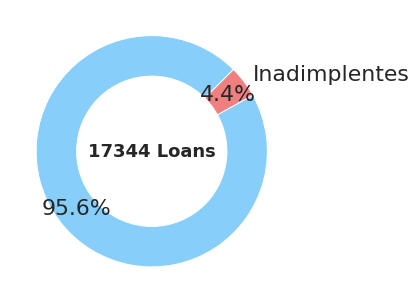

In [304]:
n_companies = df_constant['y'].value_counts().sum()
default_count = df_constant['y'].value_counts()
default_count.name = ""
default_count.index = default_count.index.map({0:"", 1:"Inadimplentes"})

ax = default_count.plot.pie(figsize=(6,6), autopct="%1.1f%%", startangle=45, colors=['lightskyblue', 'lightcoral'], pctdistance=0.82, textprops={'fontsize': 22})

my_donut=plt.Circle( (0,0), 0.65, color='white')
p=plt.gcf()
ax.text(0,0, f"{n_companies} Loans", ha='center', va='center', size=18, weight='bold')
p.gca().add_artist(my_donut)

# plt.axis("equal")
plt.tight_layout()

In [305]:
# This donut chart shows (fortunately) that the dataset is imbalanced. 
# The number of default loans disproportionately smaller than the paid loans.

### Evaluating the categorical attribute `subsegmento`

N/A                                0.555293
Comércio de Alimentos              0.064806
Alimentação Rápida                 0.053851
Bares e Restaurantes               0.048432
Vestuário                          0.040071
                                     ...   
Acessórios, Bolsas e Bijuterias    0.000115
Casa e Decoração - Outros          0.000058
Locação de Veículos                0.000058
Cias Aéreas                        0.000058
Ensino Superior e Técnico          0.000058
Name: subsegmento, Length: 74, dtype: float64


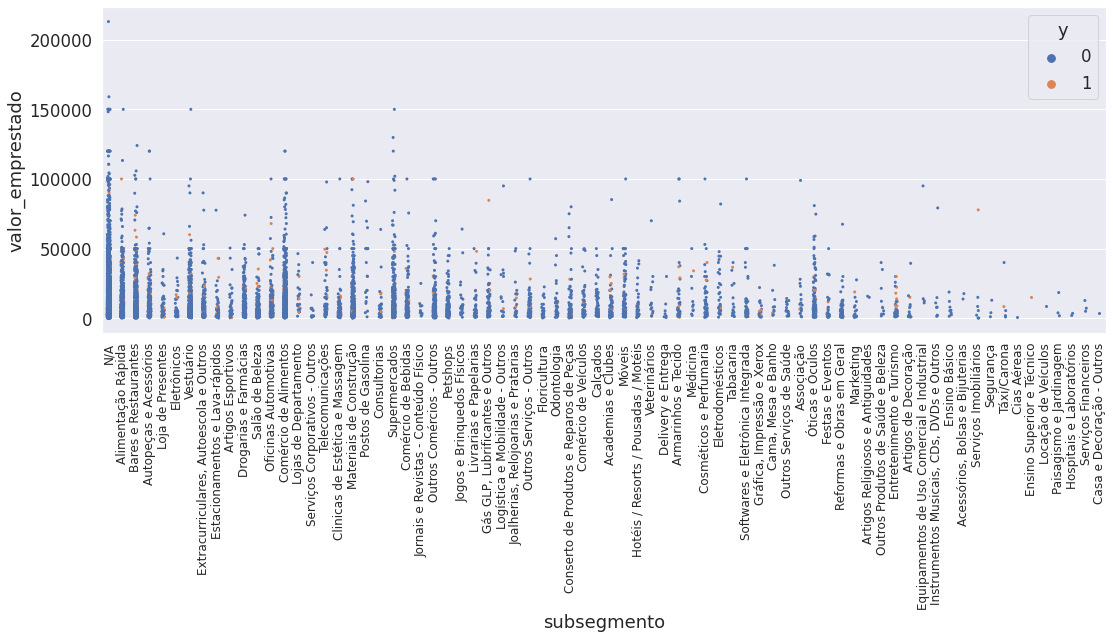

In [307]:
fig,ax = plt.subplots(figsize=(18,6))
sns.stripplot(ax=ax, x="subsegmento", hue="y", y='valor_emprestado', data=df_constant, size=3)
plt.xticks(rotation=90, fontsize=12);

print(df_constant.loc[:,'subsegmento'].value_counts(normalize=True))

N/A                                 0.555293
Alimentacao e Bebida                0.193727
Servicos                            0.067631
Industria, Construcao e Veiculos    0.048662
Comercio                            0.047394
Moda e Esports                      0.045895
Saude                               0.024908
Educacao                            0.010897
Informatica                         0.005593
Name: segmento, dtype: float64


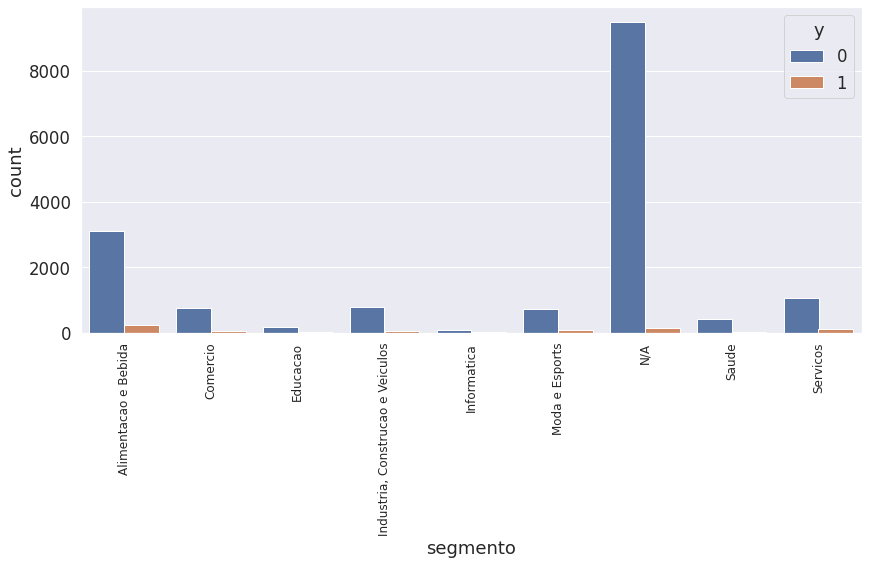

In [308]:
# Clearly there are too many categories of `subsegmento`. Half of the loans did not provide a value for subsegmento.
# Lets map this many subsegment into broader sectors
def return_key_if_contains_value(dictionary, my_value):
    for key, value in dictionary.items():
        if my_value in value:
            return key

sectors = {
    'Alimentacao e Bebida': ['Comércio de Alimentos', 'Alimentação Rápida', 'Bares e Restaurantes', 'Comércio de Bebidas', 'Supermercados'],
    'Moda e Esports': ['Vestuário', 'Calçados', 'Artigos Esportivos', 'Acessórios, Bolsas e Bijuterias'],
    'Industria, Construcao e Veiculos': ['Materiais de Construção', 'Autopeças e Acessórios', 'Comércio de Veículos', 'Gás GLP, Lubrificantes e Outros', 'Reformas e Obras em Geral', 'Postos de Gasolina', 'Estacionamentos e Lava-rápidos', 'Equipamentos de Uso Comercial e Industrial', 'Locação de Veículos'],
    'Servicos': ['Oficinas Automotivas', 'Salão de Beleza', 'Conserto de Produtos e Reparos de Peças', 'Outros Serviços - Outros', 'Delivery e Entrega', 'Telecomunicações', 'Academias e Clubes', 'Clinicas de Estética e Massagem', 'Associação', 'Cias Aéreas', 'Jornais e Revistas - Conteúdo Físico', 'Serviços Corporativos - Outros', 'Hotéis / Resorts / Pousadas / Motéis', 'Festas e Eventos', 'Gráfica, Impressão e Xerox', 'Entretenimento e Turismo', 'Consultorias', 'Logística e Mobilidade - Outros', 'Marketing', 'Serviços Imobiliários', 'Segurança', 'Táxi/Carona', 'Paisagismo e Jardinagem', 'Serviços Financeiros', 'Casa e Decoração - Outros'],
    'Saude': ['Óticas e Óculos', 'Drogarias e Farmácias', 'Outros Serviços de Saúde', 'Odontologia', 'Veterinários', 'Médicina', 'Outros Produtos de Saúde e Beleza', 'Hospitais e Laboratórios'],
    'Comercio': ['Móveis', 'Outros Comércios - Outros', 'Eletrodomésticos', 'Armarinhos e Tecido', 'Tabacaria', 'Cama, Mesa e Banho', 'Cosméticos e Perfumaria', 'Loja de Presentes', 'Lojas de Departamento', 'Jogos e Brinquedos Físicos', 'Joalherias, Relojoarias e Pratarias', 'Floricultura', 'Petshops', 'Artigos Religiosos e Antiguidades', 'Artigos de Decoração', 'Instrumentos Musicais, CDs, DVDs e Outros'],
    'Educacao': ['Extracurriculares, Autoescola e Outros', 'Ensino Básico', 'Livrarias e Papelarias', 'Ensino Superior e Técnico'],
    'Informatica': ['Eletrônicos', 'Softwares e Eletrônica Integrada']
}

df_constant['segmento'] = df_constant['subsegmento'].map(
    lambda segment: return_key_if_contains_value(sectors, segment))
df_constant['segmento'] = df_constant['segmento'].fillna('N/A')
df_constant['segmento'] = df_constant['segmento'].astype('category')

fig,ax = plt.subplots(figsize=(14,6))

sns.countplot(ax=ax, x="segmento", hue='y', data=df_constant)
plt.xticks(rotation=90, fontsize=12);

print(df_constant.loc[:,'segmento'].value_counts(normalize=True))

In [309]:
# Even though this mapping of subsegments into broader segments helped with a better grasp o the distribution of segments which took the loan,
# the high values of null entries (more then 50% N/A for this case), make this attribute not good for ml models
# lets drop these columns
df_constant.drop(columns=['segmento', 'subsegmento'], inplace=True)

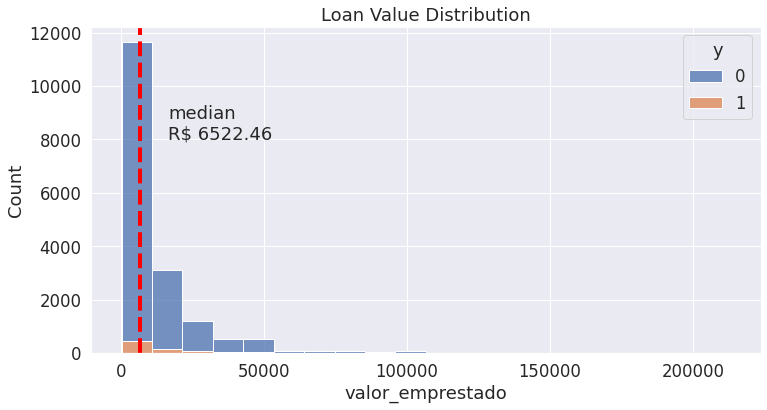

In [310]:
loan_value_per_id = df_constant[['valor_emprestado', 'y']]
median_loan_value = df_constant['valor_emprestado'].median()

fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(ax=ax, data=loan_value_per_id, stat='count', x='valor_emprestado', hue='y', multiple='stack', bins=20)
vline = plt.axvline(median_loan_value, 0,1, c='red', linestyle='--', linewidth=4)
plt.annotate(f"median\nR$ {median_loan_value:.2f}", (median_loan_value + 10000, 8000))
plt.title("Loan Value Distribution");

## What is the distribution of loan value?

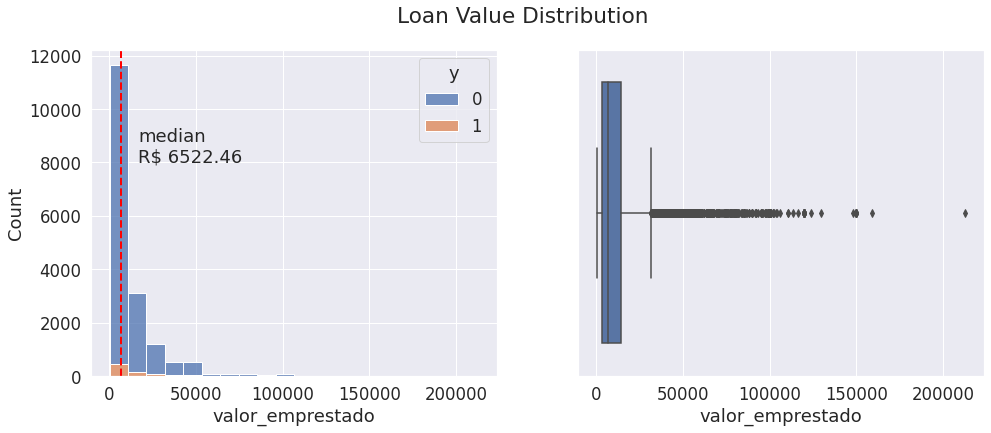

In [311]:
loan_value = df_constant[['valor_emprestado', 'y']]
median_loan_value = df_constant['valor_emprestado'].median()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16,6))
sns.histplot(ax=ax[0], data=loan_value, stat='count', x='valor_emprestado', hue='y', multiple='stack', bins=20)
ax[0].axvline(median_loan_value, 0,1, c='red', linestyle='--', linewidth=2)
ax[0].annotate(f"median\nR$ {median_loan_value:.2f}", (median_loan_value + 10000, 8000))

sns.boxplot(ax=ax[1], x=loan_value['valor_emprestado'] )

plt.suptitle("Loan Value Distribution");

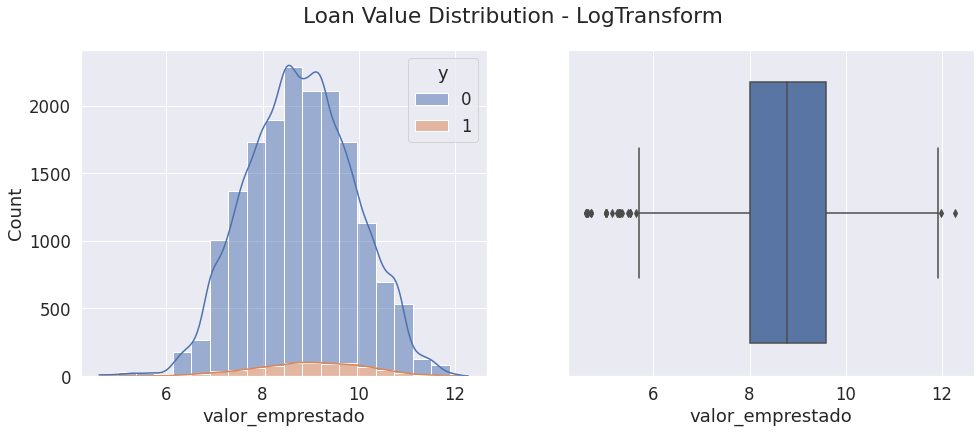

In [312]:
# The distribution is right skewed. Lets try to normalize it using log transform
loan_value = df_constant[['valor_emprestado', 'y']]
loan_value['valor_emprestado'] = np.log(loan_value['valor_emprestado'])

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16,6))
sns.histplot(ax=ax[0], data=loan_value, stat='count', x='valor_emprestado', hue='y', multiple='stack', bins=20, kde=True)
sns.boxplot(ax=ax[1], x=loan_value['valor_emprestado'] )

plt.suptitle("Loan Value Distribution - LogTransform");

## What is the Distribution of the Expected Daily Payment?

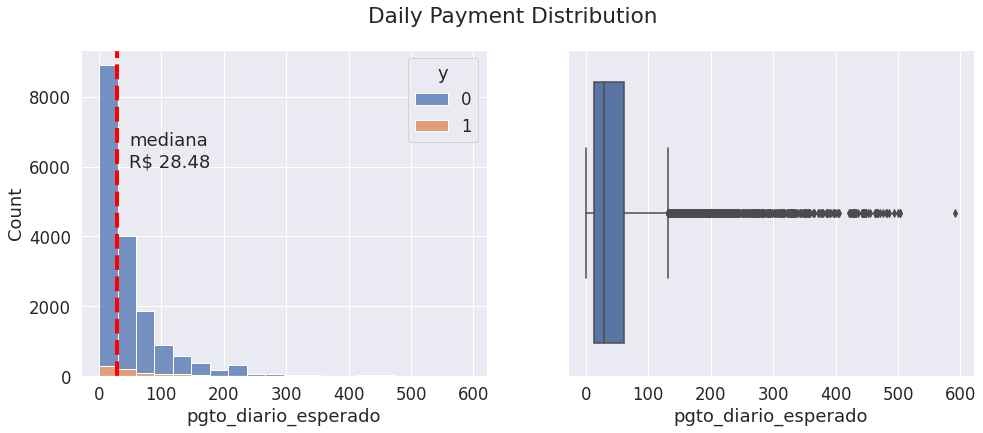

In [313]:
daily_payment = df_constant[['pgto_diario_esperado', 'y']]
median_daily_payment = df_constant['pgto_diario_esperado'].median()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16,6))
sns.histplot(ax=ax[0], data=daily_payment, x='pgto_diario_esperado', hue='y', multiple='stack', bins=20)
ax[0].axvline(median_daily_payment, 0,1, c='red', linestyle='--', linewidth=4)
ax[0].annotate(f"mediana\nR$ {median_daily_payment:.2f}", (median_daily_payment + 20, 6000))

sns.boxplot(ax=ax[1], x=daily_payment['pgto_diario_esperado'] )

plt.suptitle("Daily Payment Distribution");

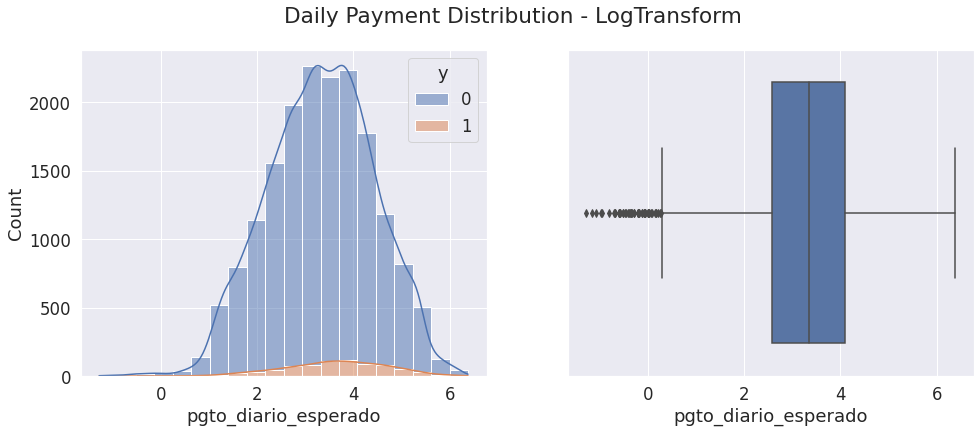

In [314]:
# This distribution is also right skewed. Lets try to normalize it too using log transform
daily_payment = df_constant[['pgto_diario_esperado', 'y']]
daily_payment['pgto_diario_esperado'] = np.log(df_constant['pgto_diario_esperado'])

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16,6))
sns.histplot(ax=ax[0], data=daily_payment, stat='count', x='pgto_diario_esperado', hue='y', multiple='stack', bins=20, kde=True)

sns.boxplot(ax=ax[1], x=daily_payment['pgto_diario_esperado'] )

plt.suptitle("Daily Payment Distribution - LogTransform");

##  What was the period in which most loans were taken?

<AxesSubplot:xlabel='desembolso', ylabel='Count'>

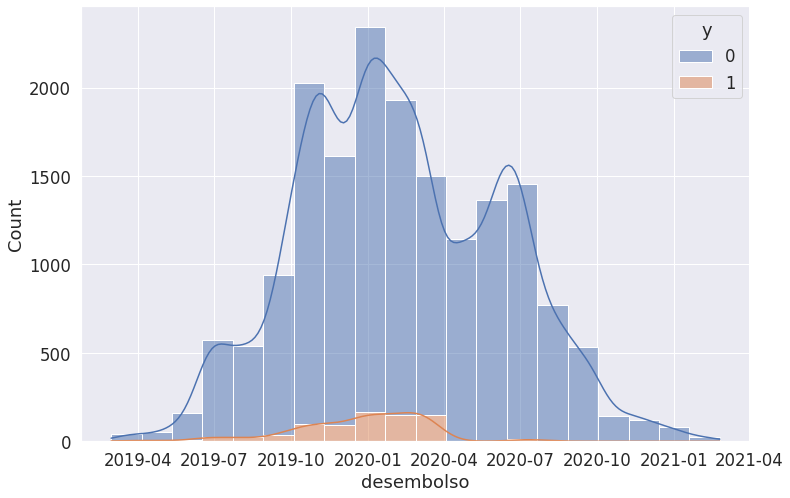

In [315]:
loan_date = df_constant[['desembolso', 'y']]

fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(ax=ax, data=loan_date, x='desembolso', hue='y', multiple='stack', kde=True, bins=20)

2020    10247
2019     7053
2021       44
Name: year, dtype: int64
6     1916
1     1769
10    1746
11    1727
12    1719
2     1515
3     1400
7     1369
9     1262
8     1019
4     1014
5      888
Name: month, dtype: int64


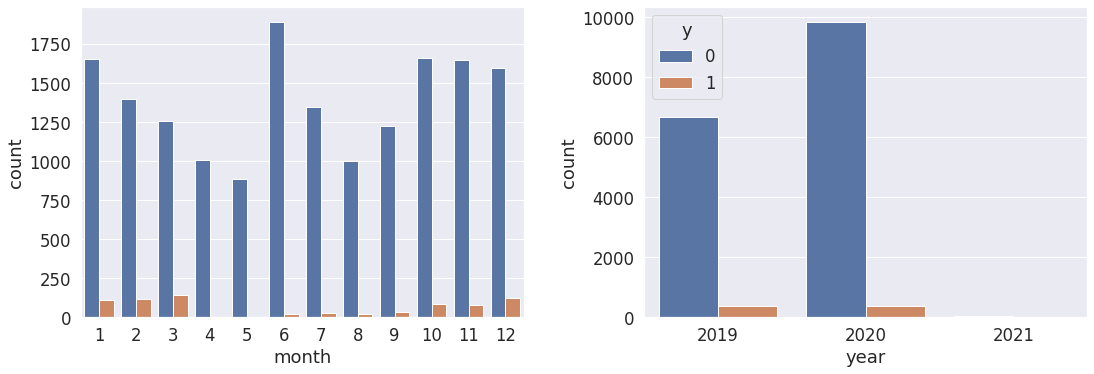

In [316]:
# As expected, the period in which the most loans were taken was during the beginning of the pandemic. As a consequence, in this period there were also a greater number of defaulters.
# Here wer are going to split the dates in months and years.

loan_date = df_constant[['desembolso', 'y']]
loan_date['month'] = loan_date['desembolso'].dt.month
loan_date['year'] = loan_date['desembolso'].dt.year

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16,6))
sns.countplot(ax=ax[0], data=loan_date, x='month', hue='y')
sns.countplot(ax=ax[1], data=loan_date, x='year', hue='y')

fig.tight_layout(pad=2)

ax[0].legend_ = None

print(loan_date['year'].value_counts())
print(loan_date['month'].value_counts())

2020    10816
2021     5664
2022      827
2019       37
Name: year, dtype: int64
9     3162
10    2617
7     2517
8     2272
11    1805
6     1397
3     1207
12     747
5      575
4      472
1      311
2      262
Name: month, dtype: int64


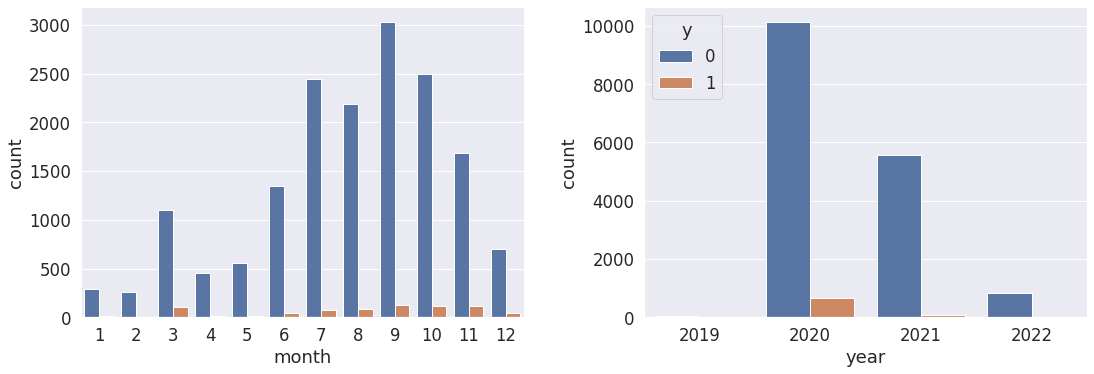

In [317]:
loan_date2 = df_constant[['vencimento', 'y']]
loan_date2['month'] = loan_date2['vencimento'].dt.month
loan_date2['year'] = loan_date2['vencimento'].dt.year

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16,6))
sns.countplot(ax=ax[0], data=loan_date2, x='month', hue='y')
sns.countplot(ax=ax[1], data=loan_date2, x='year', hue='y')

fig.tight_layout(pad=2)

ax[0].legend_ = None

print(loan_date2['year'].value_counts())
print(loan_date2['month'].value_counts())

In [318]:
# to avoid classes with too few values we are categorize the years in two bins:
df_constant['desembolso_mes'] = df_constant['desembolso'].dt.month
df_constant['desembolso_ano'] = df_constant['desembolso'].dt.year
df_constant['desembolso_ano'] = df_constant['desembolso_ano'].apply(lambda year: '2020+' if year >=2020 else '2019' )

df_constant['vencimento_mes'] = df_constant['vencimento'].dt.month
df_constant['vencimento_ano'] = df_constant['vencimento'].dt.year
df_constant['vencimento_ano'] = df_constant['vencimento_ano'].apply(lambda year: '2021+' if year >=2021 else '2020-' )

# df_constant.drop(columns=['desembolso', 'vencimento'], inplace=True)

In [319]:
df_constant

,desembolso,vencimento,valor_emprestado,pgto_diario_esperado,tempo_maximo_divida,y,desembolso_mes,desembolso_ano,vencimento_mes,vencimento_ano
6,2019-03-25,2019-12-26,7100.0,33.8852,276,0,3,2019,12,2020-
8,2019-03-25,2019-12-26,6900.0,32.9307,276,0,3,2019,12,2020-
9,2019-03-25,2019-12-26,42500.0,175.5301,276,0,3,2019,12,2020-
11,2019-03-25,2019-12-26,4200.0,19.2553,276,0,3,2019,12,2020-
12,2019-03-06,2019-12-05,7700.0,34.0856,274,0,3,2019,12,2020-
...,...,...,...,...,...,...,...,...,...,...
59428,2021-02-18,2022-06-14,28685.0,81.3566,481,0,2,2020+,6,2021+
59431,2021-02-18,2022-06-16,1348.0,4.7826,483,0,2,2020+,6,2021+
59433,2021-02-18,2022-08-16,2000.0,6.6859,544,0,2,2020+,8,2021+
59438,2021-02-23,2022-05-21,8769.0,29.5007,452,0,2,2020+,5,2021+


## What is the Distribution of maximum time to pay the loan?

<AxesSubplot:xlabel='tempo_maximo_divida', ylabel='Count'>

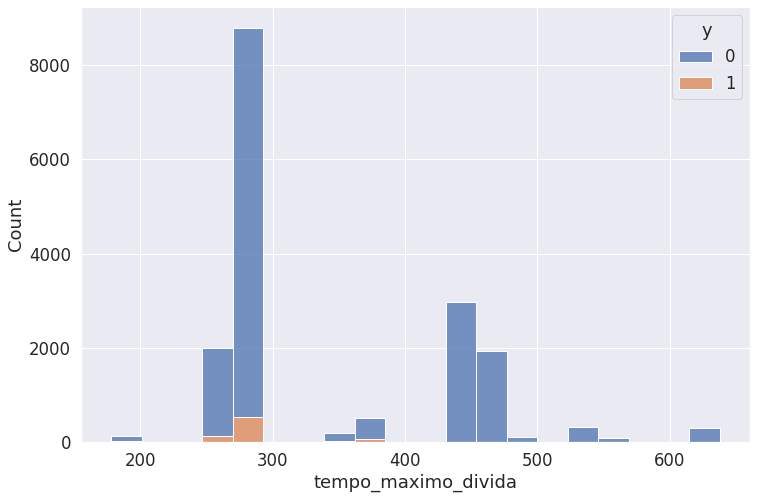

In [320]:
fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(ax=ax, data=df_constant, x='tempo_maximo_divida', hue='y', multiple='stack', bins=20)

In [321]:
# It clearly has two peaks, lets split between long loans and short loans

<AxesSubplot:xlabel='tempo_maximo_divida', ylabel='count'>

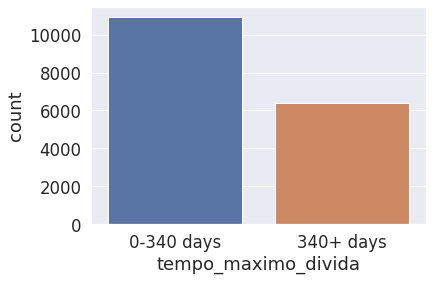

In [322]:
mean_loan_time = df_constant['tempo_maximo_divida'].mean()

df_constant['tempo_maximo_divida_bin'] = df_constant['tempo_maximo_divida'].apply(lambda duration: '0-340 days' if duration <= mean_loan_time else '340+ days')
sns.countplot(df_constant['tempo_maximo_divida_bin'])

In [478]:
iv_woe(df_constant, 'tempo_maximo_divida_bin', 'y')

    attribute  count percentage (%)       woe        iv
0  0-340 days  10936      63.053506 -0.364651  0.099236
1   340+ days   6408      36.946494  1.249369  0.340004


## In this second part, the attributes that vary with time are analyzed

In [329]:
timeseries_attributes = ['id', 'dia', 'dias_pos_desembolso', 'divida_total', 'divida_principal', 'pagamento_diario', 'amortizacao_principal_diario', 'transacionado', 'y']

timeseries_data = train_data[timeseries_attributes].reset_index(drop=True)

dtypes = {
    'id': int,
    'dia': 'datetime64',
    'dias_pos_desembolso': int,
    'divida_total': float,
    'divida_principal': float,
    'pagamento_diario': float,
    'amortizacao_principal_diario': float,
    'transacionado': float,
    'y': int
}

timeseries_data = timeseries_data.astype(dtypes)

In [330]:
timeseries_data

,id,dia,dias_pos_desembolso,divida_total,divida_principal,pagamento_diario,amortizacao_principal_diario,transacionado,y
0,6,2019-03-25,0,7197.98,7100.0,0.00,0.0,664.00,0
1,6,2019-03-26,1,7212.25,7100.0,0.00,0.0,0.00,0
2,6,2019-03-27,2,7226.54,7100.0,0.00,0.0,150.00,0
3,6,2019-03-28,3,7207.22,7100.0,33.64,0.0,0.00,0
4,6,2019-03-29,4,7221.51,7100.0,0.00,0.0,0.00,0
...,...,...,...,...,...,...,...,...,...
2889108,59438,2021-02-28,5,8844.83,8769.0,0.00,0.0,0.00,0
2889109,59443,2021-02-25,0,8935.83,8902.0,0.00,0.0,16.70,0
2889110,59443,2021-02-26,1,8945.30,8902.0,2.56,0.0,183.43,0
2889111,59443,2021-02-27,2,8957.34,8902.0,0.00,0.0,0.00,0


In [331]:
# As stated in an email sent by the challange organizers, the prediction should 
# be made on the ninetieth day. Therefore, in order to eliminate target leakage, 
# the analysis will also be done considering all records up to the ninetieth.
timeseries_data = timeseries_data.loc[timeseries_data['dias_pos_desembolso'] < 90]
timeseries_data.reset_index(drop=True, inplace=True)

In [332]:
# Since the analysis of the timeseries attributies is dependent on aggregating the data and the dataset has many
# many rows (2889113 to be exact), i am gonna extract a subset of the dataset and work with it interchangeably with
# the raw trainning data set

unique_ids = np.unique(timeseries_data['id'])

np.random.seed(1)
np.random.shuffle(unique_ids)
subset_ids = unique_ids[:2000]

timeseries_data_subset = timeseries_data.loc[timeseries_data['id'].isin(subset_ids)]
timeseries_data_subset.reset_index(drop=True, inplace=True)

In [333]:
timeseries_data_subset

,id,dia,dias_pos_desembolso,divida_total,divida_principal,pagamento_diario,amortizacao_principal_diario,transacionado,y
0,12,2019-03-06,0,7806.46,7700.00,0.00,0.00,0.00,0
1,12,2019-03-07,1,7816.97,7700.00,0.00,0.00,957.95,0
2,12,2019-03-08,2,7786.66,7700.00,40.83,0.00,707.35,0
3,12,2019-03-09,3,7797.14,7700.00,0.00,0.00,1330.21,0
4,12,2019-03-10,4,7807.64,7700.00,0.00,0.00,1123.67,0
...,...,...,...,...,...,...,...,...,...
167811,59425,2021-02-24,6,994.18,994.19,2.44,0.63,155.00,0
167812,59425,2021-02-25,7,992.96,992.97,3.03,1.22,170.00,0
167813,59425,2021-02-26,8,991.46,991.47,3.31,1.50,445.00,0
167814,59425,2021-02-27,9,993.27,991.47,0.00,0.00,642.00,0


### Sanity Check

### Are there any unregistered days of the loan in the dataset?

In [334]:
# The first analysis will be related to the `dias_pos_desembolso` attribute. 
# We will check if that for each loan all days are registered i.e. the days registered 
# start at 0 and follows a sequential (1,2,3,4,...) order without jumping any day. 

def check_if_list_of_ints_start_0_and_is_sorted(int_list):
    ideal_list = list(range(0, max(int_list) + 1))

    if len(ideal_list) != len(int_list):
        return False

    if sorted(int_list) == ideal_list:
        return True
    else:
        return False

missing_days_index = []

for loan_index in subset_ids:
    loan_timeseries_tmp = timeseries_data_subset.loc[timeseries_data_subset['id'].isin([loan_index])]
    days_after_loan = loan_timeseries_tmp['dias_pos_desembolso']
    if not check_if_list_of_ints_start_0_and_is_sorted(days_after_loan):
        missing_days_index.append(loan_index)
        
print(f"{len(missing_days_index)} loans with missing rows in the dataset")

6 loans with missing rows in the dataset


In [335]:
# In this subset we found 7 loans with missing rows, which means that this incident must be happening much more in the raw data.
# This pattern in the data will be taken into account while we are creating features for the ml models 

# there are also loans with just one row registered
timeseries_data.groupby('id')['dias_pos_desembolso'].max().value_counts()

89    13944
62      101
83       93
76       88
69       88
      ...  
2         5
4         4
3         4
1         1
0         1
Name: dias_pos_desembolso, Length: 90, dtype: int64

### If the loans stop being registered before the last possible day of the loan (`vencimento`) this means that the loan was paid?

In [336]:
train_data['tempo_maximo_divida'] = (
    train_data.vencimento - train_data.desembolso).dt.days

check_default_for_early_ended_loans = train_data.groupby('id')[['tempo_maximo_divida', 'dias_pos_desembolso', 'y']].agg({
    'tempo_maximo_divida': 'max',
    'dias_pos_desembolso': 'max',
    'y': 'median'
})
check_default_for_early_ended_loans['dif_tempo_pagamento'] = check_default_for_early_ended_loans[
    'tempo_maximo_divida'] - check_default_for_early_ended_loans['dias_pos_desembolso']

dtypes = {
    'dias_pos_desembolso': int,
    'dif_tempo_pagamento': int,
    'y': int
}

check_default_for_early_ended_loans = check_default_for_early_ended_loans.astype(
    dtypes)
check_default_for_early_ended_loans = check_default_for_early_ended_loans.loc[
    check_default_for_early_ended_loans['dif_tempo_pagamento'] > 0]

print(f"From {check_default_for_early_ended_loans.y.size} payments that ended before the last day, only {(check_default_for_early_ended_loans.y== 1).sum()} were Default")

From 14923 payments that ended before the last day, only 86 were Default


In [337]:
# So, the answer of 1.2 is false.

### Exploring Timeseries Attributes

### The exploratory Analysis of the timeseries attributes is done in two ways. First, a dashboard is created in the notebook `02_dashboard.ipynb` to individually investigate the variation of timeseries attributes. The dashboard is very useful to to grasp patterns between the loans that are paid and the ones that are not. Second, in the following cells, the attributes `divida_total`, `divida_principal`, `pagamento_diario`, 	`amortizacao_principal_diario` and	`transacionado` are normalized according to `valor_emprestado`. This tranformation should give a more comparative bias in between loans than working the raw values.

In [338]:
%%time
timeseries_data_norm = timeseries_data_subset.copy()
unique_ids = np.unique(timeseries_data_norm['id'])
timeseries_attributes = ['id', 'divida_total', 'divida_principal', 'pagamento_diario', 'amortizacao_principal_diario', 'transacionado']
timeseries_data_norm_values = timeseries_data_norm[timeseries_attributes].values

for loan_index in unique_ids:
    rows = loan_index == timeseries_data_norm_values[:,0]
    loan_value = df_constant.loc[loan_index, 'valor_emprestado']
    
    timeseries_data_norm_values[rows,1:] /= loan_value
    
timeseries_data_norm[timeseries_attributes] = timeseries_data_norm_values
timeseries_data_norm.id = timeseries_data_norm.id.astype(int)

CPU times: user 1.83 s, sys: 11.9 ms, total: 1.84 s
Wall time: 1.84 s


In [339]:
timeseries_data_norm

,id,dia,dias_pos_desembolso,divida_total,divida_principal,pagamento_diario,amortizacao_principal_diario,transacionado,y
0,12,2019-03-06,0,1.013826,1.00000,0.000000,0.00000,0.000000,0
1,12,2019-03-07,1,1.015191,1.00000,0.000000,0.00000,0.124409,0
2,12,2019-03-08,2,1.011255,1.00000,0.005303,0.00000,0.091864,0
3,12,2019-03-09,3,1.012616,1.00000,0.000000,0.00000,0.172755,0
4,12,2019-03-10,4,1.013979,1.00000,0.000000,0.00000,0.145931,0
...,...,...,...,...,...,...,...,...,...
167811,59425,2021-02-24,6,0.994180,0.99419,0.002440,0.00063,0.155000,0
167812,59425,2021-02-25,7,0.992960,0.99297,0.003030,0.00122,0.170000,0
167813,59425,2021-02-26,8,0.991460,0.99147,0.003310,0.00150,0.445000,0
167814,59425,2021-02-27,9,0.993270,0.99147,0.000000,0.00000,0.642000,0


## Lets check the distribution of normalized attributes `normalized pagamento_diario`, `amortizacao_principal_diario` and `transacionado`

<AxesSubplot:xlabel='transacionado'>

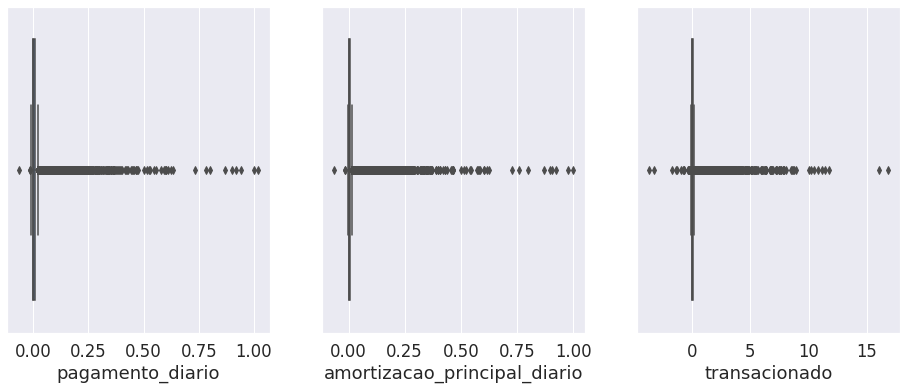

In [340]:
fig,ax= plt.subplots(nrows=1, ncols=3, figsize=(16,6))

sns.boxplot(ax=ax[0], data=timeseries_data_norm, x='pagamento_diario')
sns.boxplot(ax=ax[1], data=timeseries_data_norm, x='amortizacao_principal_diario')
sns.boxplot(ax=ax[2], data=timeseries_data_norm, x='transacionado')

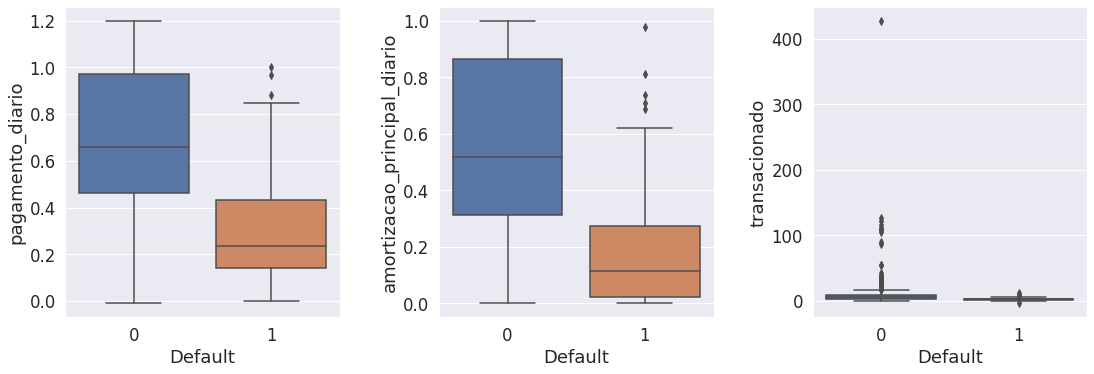

In [341]:
# As expected, the daily payment/amortization/transacation is just a small fraction of the whole loan
# lets check the distribution of these daily payments summed
summed_daily = timeseries_data_norm.groupby('id')[['pagamento_diario', 'amortizacao_principal_diario', 'transacionado', 'y']].agg({
    'pagamento_diario': sum,
    'amortizacao_principal_diario': sum,
    'transacionado': sum,
    'y': 'median'
})
summed_daily.reset_index(drop=True, inplace=True)
fig,ax= plt.subplots(nrows=1, ncols=3, figsize=(16,6))

sns.boxplot(ax=ax[0], data=summed_daily, x='y', y='pagamento_diario')
sns.boxplot(ax=ax[1], data=summed_daily, x='y', y='amortizacao_principal_diario')
sns.boxplot(ax=ax[2], data=summed_daily, x='y', y='transacionado')

for axi in ax:
    axi.set_xlabel('Default')
    
fig.tight_layout(pad=2)

In [342]:
# Here the obvious is confirmed who payed more until the ninetieth is more prone to fully paying the loan.
# Here we also check that `transacionado` attribute has a lot of outliers... (and usually these ids are not default)

In [343]:
### Fitting a linear curve into debt payment

In [344]:
timeseries_data_norm

,id,dia,dias_pos_desembolso,divida_total,divida_principal,pagamento_diario,amortizacao_principal_diario,transacionado,y
0,12,2019-03-06,0,1.013826,1.00000,0.000000,0.00000,0.000000,0
1,12,2019-03-07,1,1.015191,1.00000,0.000000,0.00000,0.124409,0
2,12,2019-03-08,2,1.011255,1.00000,0.005303,0.00000,0.091864,0
3,12,2019-03-09,3,1.012616,1.00000,0.000000,0.00000,0.172755,0
4,12,2019-03-10,4,1.013979,1.00000,0.000000,0.00000,0.145931,0
...,...,...,...,...,...,...,...,...,...
167811,59425,2021-02-24,6,0.994180,0.99419,0.002440,0.00063,0.155000,0
167812,59425,2021-02-25,7,0.992960,0.99297,0.003030,0.00122,0.170000,0
167813,59425,2021-02-26,8,0.991460,0.99147,0.003310,0.00150,0.445000,0
167814,59425,2021-02-27,9,0.993270,0.99147,0.000000,0.00000,0.642000,0


In [348]:
timeseries_data_norm

,id,dia,dias_pos_desembolso,divida_total,divida_principal,pagamento_diario,amortizacao_principal_diario,transacionado,y
0,12,2019-03-06,0,1.013826,1.00000,0.000000,0.00000,0.000000,0
1,12,2019-03-07,1,1.015191,1.00000,0.000000,0.00000,0.124409,0
2,12,2019-03-08,2,1.011255,1.00000,0.005303,0.00000,0.091864,0
3,12,2019-03-09,3,1.012616,1.00000,0.000000,0.00000,0.172755,0
4,12,2019-03-10,4,1.013979,1.00000,0.000000,0.00000,0.145931,0
...,...,...,...,...,...,...,...,...,...
167811,59425,2021-02-24,6,0.994180,0.99419,0.002440,0.00063,0.155000,0
167812,59425,2021-02-25,7,0.992960,0.99297,0.003030,0.00122,0.170000,0
167813,59425,2021-02-26,8,0.991460,0.99147,0.003310,0.00150,0.445000,0
167814,59425,2021-02-27,9,0.993270,0.99147,0.000000,0.00000,0.642000,0


### Aggregating timeseries data into some new attributes

### Here I am creating 5 variables by aggregating the timeseries attributes into a single dataframe:
#### `divida_total_menos_principal_area` is the approximated area of curve made by the data points of divida_total - divida_principal
#### `divida_total_variacao`  is the inital loan value - the value at the day of prediction
#### `coef_esperado_decaimento_divida` is the linear coefficient of the line that fits the expected debt variation
#### `coef_fitado_decaimento_divida`is the linear coefficient of the line that fits the main debt variation (counted from y axis)
#### `score_do_fit`  is the score of the fit of the line that fits the main debt variation (counted from y axis)

In [396]:
unique_idxs = np.unique(timeseries_data_norm.id)

timeseries_attributes = [
    'id', 
    'dias_pos_desembolso', 
    'divida_total', 
    'divida_principal', 
    'pagamento_diario', 
    'amortizacao_principal_diario', 
    'transacionado',
]

new_attributes = [
    "divida_total_menos_principal_area",
    "divida_total_variacao",
    "coef_esperado_decaimento_divida",
    "coef_fittado_decaimento_divida",
    "score_do_fit",
]

df_fit_values = np.zeros((len(unique_idxs), len(new_attributes)))

timeseries_data_norm_values = timeseries_data_norm[timeseries_attributes].values

for i, unique_id in enumerate(unique_idxs):
    id_rows = timeseries_data_norm_values[:,0] == unique_id
    tmp_arr_num = timeseries_data_norm_values[id_rows, :]
    
    # getting constant attributes
    valor_emprestado = df_constant.loc[unique_id, 'valor_emprestado']
    pgto_diario_esperado = df_constant.loc[unique_id, 'pgto_diario_esperado']
    duracao_esperada = df_constant.loc[unique_id, 'tempo_maximo_divida']
    
    #if loan has only one row it is duplicated
    if id_rows.sum() == 1:
        tmp_arr_num = np.r_[tmp_arr_num, tmp_arr_num]
        tmp_arr_num[1,1] = tmp_arr_num[0,1] + 1

    # getting timeseries attributes
    dias_pos_desembolso = tmp_arr_num[:, 1]
    divida_total = tmp_arr_num[:, 2]
    divida_principal = tmp_arr_num[:, 3]
    pagamento_diario = tmp_arr_num[:, 4]
    amortizacao_principal_diario = tmp_arr_num[:, 5]
    transacionado = tmp_arr_num[:, 6]

    tmp_total_minus_main_debt_area = np.trapz(
    divida_total - divida_principal)

    # if positive the debt decrease
    tmp_total_debt_variation = divida_total[0] - divida_total[-1]

    tmp_expected_coef_of_debt_payment = - \
        divida_total[0] / duracao_esperada

    tmp_expected_coef_of_debt_payment = tmp_expected_coef_of_debt_payment * -1

    y = divida_total * 100
    X = dias_pos_desembolso
    fit, tmp_linear_regression_score, _, _, _ = np.polyfit(
        X, y, deg=1, full=True)
    
    # if the fit is perfect the score is empty, so i set it to 0
    if tmp_linear_regression_score.size == 0:
        tmp_linear_regression_score = 0

    tmp_fitted_coef_of_debt_payment = -1 * fit[0]

    df_fit_values[i, :] = [
        tmp_total_minus_main_debt_area,
        tmp_total_debt_variation,
        tmp_expected_coef_of_debt_payment,
        tmp_fitted_coef_of_debt_payment,
        tmp_linear_regression_score,
    ]
    
df_fit = pd.DataFrame(index=unique_idxs, columns=new_attributes, data=df_fit_values)
df_new_attributes = df_fit.merge(df_constant['y'], left_index=True, right_index=True)

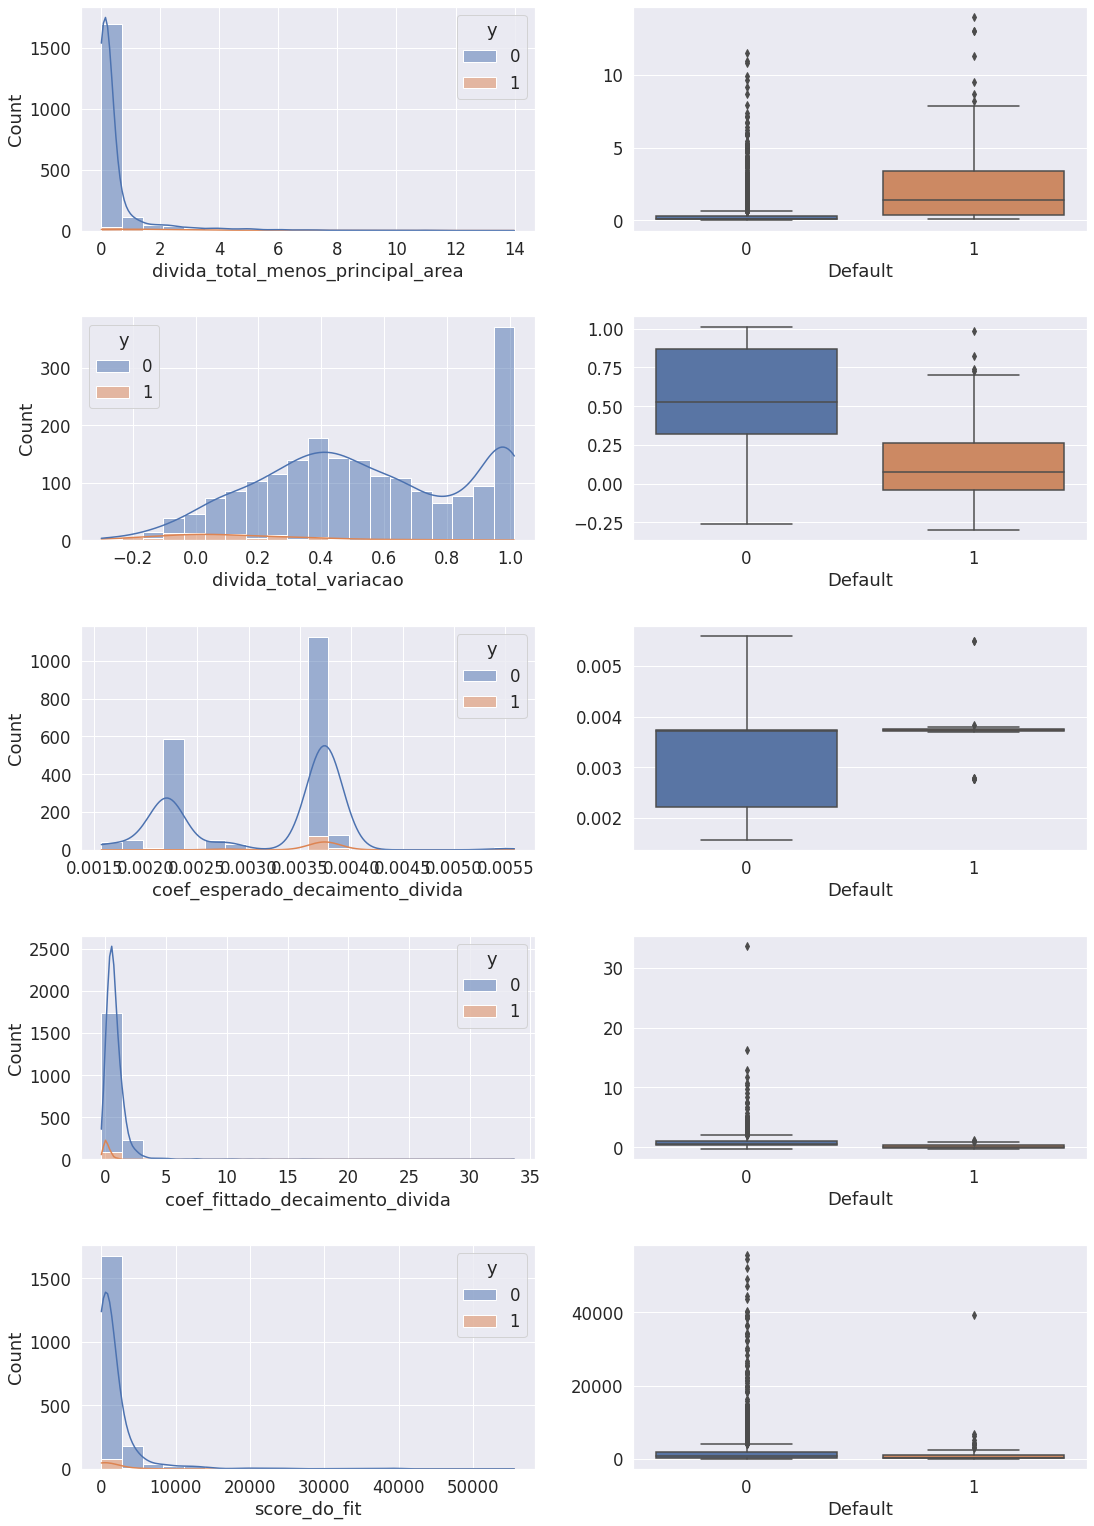

In [398]:
fig, ax = plt.subplots(nrows=len(new_attributes), ncols=2, figsize=(16,22))

for i, attribute in enumerate(new_attributes):
    sns.histplot(ax=ax[i,0], data=df_new_attributes, x=attribute, hue='y', multiple='stack', bins=20, kde=True)
    sns.boxplot(ax=ax[i,1], data=df_new_attributes, x='y', y=attribute)
    ax[i,1].set_ylabel('')
    ax[i,1].set_xlabel('Default')
    
fig.tight_layout(pad=2)

In [ ]:
#clearly coef_fittado_decaimento_divida have a very similar distribution to tempo_maximo_divida (Since one is 
# most likely calculated based on the other), sso this new attribute is discarted.
# score_do_fit, coef_fittado_decaimento_divida and coef_espearado_decaimento_divida are skewed, so these we are transform
# to look for a ditribution that looks more like a normal one.
# divida_total_variacao clearly has two peakes. So this attribute is going to be binned.

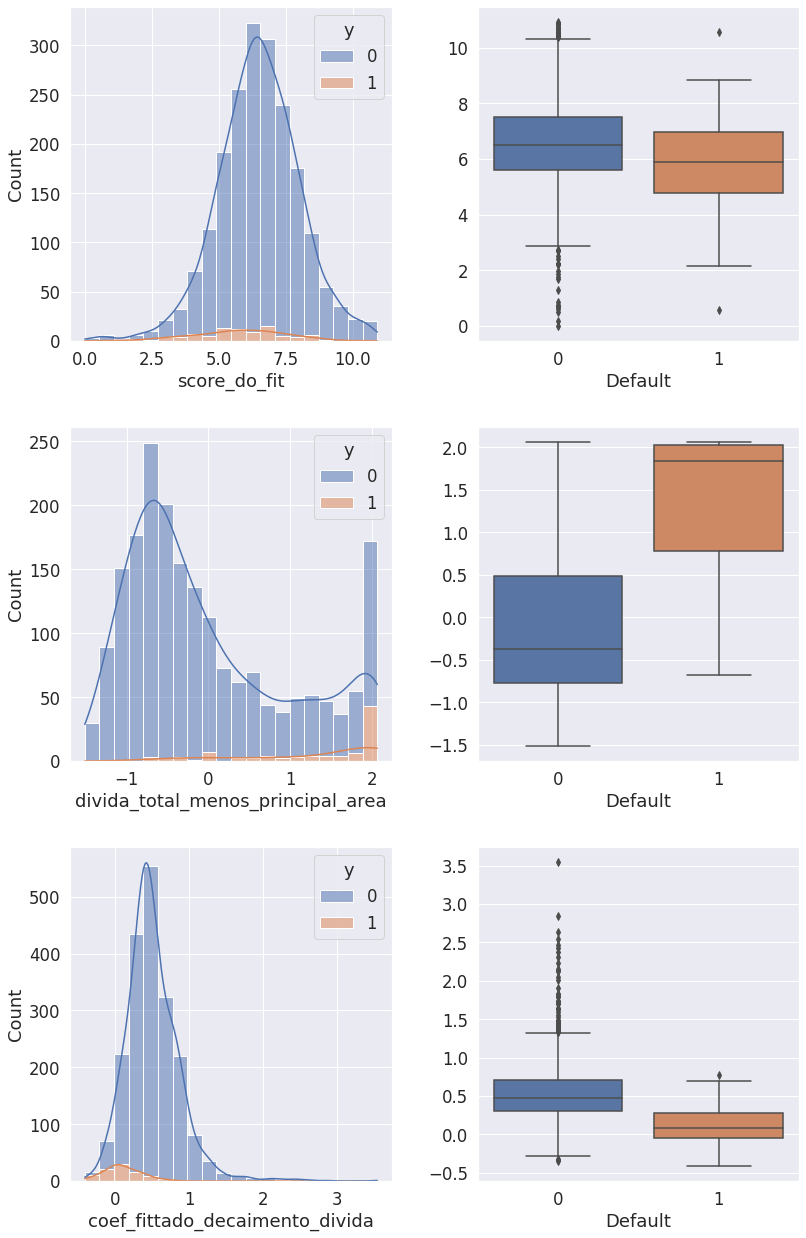

In [457]:
# Transforming
from sklearn.preprocessing import PowerTransformer

transformed_attributes = ['score_do_fit', 'divida_total_menos_principal_area', 'coef_fittado_decaimento_divida']

df_new_attributes_transformed = df_new_attributes.copy()
df_new_attributes_transformed['score_do_fit'] = np.log1p(df_new_attributes['score_do_fit'])
df_new_attributes_transformed['coef_fittado_decaimento_divida'] = np.log1p(df_new_attributes['coef_fittado_decaimento_divida'])
df_new_attributes_transformed['divida_total_menos_principal_area'] = PowerTransformer().fit_transform(df_new_attributes['divida_total_menos_principal_area'].values.reshape(-1,1))


fig, ax = plt.subplots(nrows=len(transformed_attributes), ncols=2, figsize=(12,18))

for i, attribute in enumerate(transformed_attributes):
    sns.histplot(ax=ax[i,0], data=df_new_attributes_transformed, x=attribute, hue='y', multiple='stack', bins=20, kde=True)
    sns.boxplot(ax=ax[i,1], data=df_new_attributes_transformed, x='y', y=attribute)
    ax[i,1].set_ylabel('')
    ax[i,1].set_xlabel('Default')
    
fig.tight_layout(pad=2)

In [448]:
 # divida_total_menos_principal didnt looked good after transforming. So, besides divida_total_variacao, divida_total_menos_principal
 # is also going to be binned

<AxesSubplot:ylabel='Frequency'>

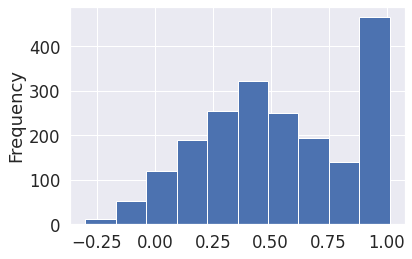

In [461]:
df_new_attributes['divida_total_variacao'].plot.hist()

<AxesSubplot:xlabel='divida_total_menos_principal_area', ylabel='count'>

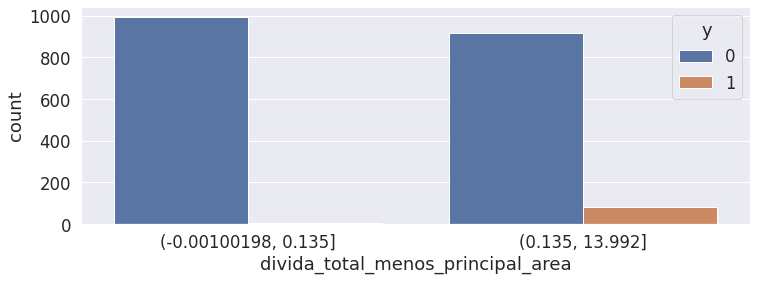

In [488]:
df_new_attributes_binned = df_new_attributes.copy()
df_new_attributes_binned['divida_total_menos_principal_area'] = pd.qcut(df_new_attributes['divida_total_menos_principal_area'], 2)

fig,ax = plt.subplots(figsize=(12,4))
sns.countplot(data=df_new_attributes_binned, x='divida_total_menos_principal_area', hue='y')

In [489]:
iv_woe(df_new_attributes_binned, 'divida_total_menos_principal_area', 'y')

              attribute count percentage (%)       woe        iv
0  (-0.00100198, 0.135]  1000           50.0  2.054929  0.932428
1       (0.135, 13.992]  1000           50.0 -0.665849  0.302131


In [ ]:
df_new_attributes_binned['divida_total_variacao'] = pd.qcut(df_new_attributes['divida_total_variacao'], 2)

fig,ax = plt.subplots(figsize=(12,4))
sns.countplot(data=df_new_attributes_binned, x='divida_total_menos_principal_area', hue='y')

In [ ]:
mean_loan_time = df_constant['tempo_maximo_divida'].mean()

df_constant['tempo_maximo_divida_bin'] = df_constant['tempo_maximo_divida'].apply(lambda duration: '0-340 days' if duration <= mean_loan_time else '340+ days')
sns.countplot(df_constant['tempo_maximo_divida_bin'])